<a href="https://colab.research.google.com/github/gassantos/phd-guided-study/blob/main/Analise_Rastreabilidade_Resumo_DocumentosVotos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Transformações de Dados no Texto de $Documento$ de $Voto$ para $Resumo$**


Foi realizada uma análise de votos de processos, utilizando técnicas de NLP combinadas com IA Generativa. O objetivo é extrair informações relevantes, a fim de garantir estados de transformação durante a geração de resumo a partir do conteúdo íntegro do voto de processo.  A análise também apresentou a geração de embeddings para os resumos geradaos e a aplicação de técnicas de clustering para fins de comparaçãos.

Define-se a chave da API do Google e configura o modelo generativo Gemini 1.5 flash.


### **Funções Auxiliares:**

São definidas várias funções para:

* `get_text_pdf(filename: str)`: Extrai texto de arquivos PDF.
* `get_text_doc(filename: str)`: Extrai texto de documentos do Word.
* `get_len_tokens(text: str)`: Conta o número de tokens em um texto.
* `get_length_resumo(text: str)`: Calcula o comprimento proporcional de um resumo (20% do texto).
* `get_last_parecer(resumos: list)`: Obtém o último parágrafo de cada resumo.
* `get_parecer_mpinstrutivo(texto: str)`: Extrai os pareceres do Ministério Público de Contas.
* `get_decisao_voto(texto: str)`: Extrai a decisão do voto do relator.
* `get_status_parecer(pareceres: list)`: Define o status do parecer (de acordo, desacordo, parcialmente de acordo).
* `get_numero_processo(texto: str)`: Extrai o número do processo.
* `get_response(text:str, prompt:str='')`: Gera uma resposta de texto com base em um prompt fornecido para um modelo de linguagem grande (LLM).
* `get_embeddings(text: str, chunk_size: int = 2048)`: Gera embeddings para o texto dado usando o modelo GEMINI_EMBEDD.

### **Carregamento e Pré-Processamento dos Dados:**

* Carrega dados de um arquivo Excel 'doc_votos.xlsx', criando um DataFrame.
* Ordena os votos pelo comprimento do texto.
* Filtra os votos que contenham "APOSENTADORIA" ou "REPRESENTAÇÃO" no assunto.

### **Processamento dos Dados:**

Itera sobre os processos selecionados, extraindo:

* Resumo do voto utilizando o modelo de linguagem grande.
* Entidades, usando uma função de resposta à pergunta (Q&A).
* Parecer do Ministério Público de Contas.
* Decisão do voto.
* Processamento de texto:  Aplica Stemming e Lemmatização para criar diferentes versões do texto.

Os resultados são armazenados em um novo DataFrame chamado `votos`.

### **Geração de Embeddings:**

Utiliza a função `get_embeddings` para gerar embeddings dos resumos,  em suas três versões (original, com Stemming e com Lemmatização). Os embeddings são adicionados ao DataFrame `grupos_embeddings`.

### **Análise Exploratória e Visualização:**

* Agrupa os dados pelo parecer e gera um gráfico de barras horizontais para visualizar a distribuição de pareceres.
* Utiliza t-SNE para reduzir a dimensionalidade dos embeddings gerados para os resumos (nas três versões).
* Plota os dados em um gráfico de dispersão, colorindo os pontos pelo parecer, para visualização dos clusters.


In [ ]:
# Instalando bibliotecas
!pip install -q gdown openai langchain langchain-community unidecode
!pip install -q tiktoken cohere pypdf python-docx docx2txt openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.7/249.7 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.9 MB/s eta 0:00:00


In [ ]:
# Importando as bibliotecas necessárias
import os
import openai
import tiktoken
import spacy
import pandas as pd
import re
import logging
import time
import nltk
import google.generativeai as genai
import zipfile
import json

from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from unidecode import unidecode
from langchain.document_loaders import PyPDFLoader
from docx import Document
from datetime import datetime, timedelta
from google.colab import userdata
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Excel : https://docs.google.com/spreadsheets/d/1ikM6ZmlaVNPAIlwd_pimZec0JyKh7urb
downloaded = drive.CreateFile({'id':'1ikM6ZmlaVNPAIlwd_pimZec0JyKh7urb'})
downloaded.GetContentFile('doc_votos.xlsx')

# Create directory to Images
# !mkdir "Graficos"; mkdir "Modelos"

In [ ]:
# Download do modelo small para idioma português
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 86.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Baixar recursos do nltk se necessário
nltk.download('stopwords')
nltk.download('rslp')

# Carregar stopwords para português
STOPWORDS = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


In [ ]:
def get_text_no_stopwords(text: str) -> list[str]:

    # Tokenização (separar palavras)
    tokens = text.split()

    # Remoção de stopwords
    tokens = [word for word in tokens if word not in STOPWORDS]
    return tokens

In [ ]:
# Exemplo para obter datas com timedelta
def get_mondaydate_onweek():
    now = datetime.now()
    monday = now - timedelta(days = now.weekday())
    print(monday.date())

# Coloca os arquivos no diretório especificado
def extract_zip(zip_file_path, extract_dir):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

# Função de pré-processamento com lematização e stemming
def preprocess_text(text, use_lemma=False, use_stemm=False):
    # Carregar o modelo de lematização em português do spaCy
    nlp = spacy.load("pt_core_news_sm")

    # Carregar o stemmer RSLP para português
    stemmer = RSLPStemmer()

    # 1. Normalização (lowercase)
    text = text.lower()

    # 2. Remoção de acentuação (diacríticos)
    text = unidecode(text)  # Remove acentos como á, é, í

    # 3. Remoção de pontuação e caracteres especiais
    text = re.sub(r'[^a-z\s]', '', text)  # Remove tudo que não for letras

    # 4. Remoção de stopwords
    tokens = get_text_no_stopwords(text)

    # 5. Lematização (opcional)
    if use_lemma:
        # Usando spaCy para lematização
        doc = nlp(" ".join(tokens))  # Processa o texto tokenizado
        tokens = [token.lemma_ for token in doc]  # Substitui por lemmas

    # 6. Stemming (opcional)
    if use_stemm:
        # Usando RSLPStemmer para stemming
        tokens = [stemmer.stem(word) for word in tokens]  # Aplica o stemmer

    # 7. Remoção de múltiplos espaços
    processed_text = ' '.join(tokens)

    return processed_text

In [ ]:
# Exemplo de uso
texto_exemplo = "Olá, como você está? Correndo, brincando e aprendendo sempre!"
texto_limpo = preprocess_text(texto_exemplo)
print("\n",texto_exemplo)
print("\n",texto_limpo)


 Olá, como você está? Correndo, brincando e aprendendo sempre!

 ola voce correndo brincando aprendendo sempre


In [ ]:
print(f"Iniciando a aplicação às {datetime.now():%Y-%m-%d %H:%M:%S}")

PATTERN_PROCESSO        =  "[0-9]{3}.[0-9]{3}-\d\/[0-9]{4}"
PATTERN_VOTO_RELATOR    = r"\barquivamento\b|\bcomunicação\b|encaminhamento\b"
PATTERN_STATUS_PARECER  = r"de acordo|parcialmente|desacordo"
PATTERN_PARECER_MPC_SGE = r"posiciono-me|de acordo|parcialmente|desacordo|Ministério Público de Contas|\
                            Parquet de Contas|Corpo Instrutivo|Corpo Técnico|Unidade Técnica|Relatório de Auditoria"

# # Main run initialized based on the tasks for Summarization and Text Extraction
# # Settings for Azure OpenAI
# OPENAI_KEY = "b13101a457404d54a9045b5281fd71e1"
MODEL_GPT_35_TURBO = "gpt-3.5-turbo-0301"
MODEL_GOOGLE_GEMINI = "gemini-1.5-flash"

# os.environ['OPENAI_API_KEY'] = "b13101a457404d54a9045b5281fd71e1
# os.environ['AZURE_OPENAI_KEY']= OPENAI_KEY
# os.environ['AZURE_OPENAI_ENDPOINT']="https://testedez2023.openai.azure.com/"
# openai.api_type = "azure"
# openai.api_base = os.getenv("AZURE_OPENAI_ENDPOINT")
# openai.api_key = os.getenv("AZURE_OPENAI_KEY")

Iniciando a aplicação às 2024-11-21 18:50:57


In [ ]:
genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))
model = genai.GenerativeModel(model_name="models/gemini-1.5-flash")

In [ ]:
def get_text_pdf(filename: str):
    """Function to extract text from PDF"""
    loader = PyPDFLoader(filename)
    pages = loader.load_and_split()
    text=""
    for page in pages:
        text += page.page_content
    return text

def get_text_doc(filename: str):
    """Function to extract text from Word Document"""
    f = open(filename, 'rb')
    doc = Document(f)
    f.close()

    text = ""
    for paragraph in doc.paragraphs:
        text += paragraph.text+'\n'
    return text


def get_len_tokens(text:str) -> int:
    """Counting Tokens for Summarization Models"""
    encoding = tiktoken.encoding_for_model(MODEL_GPT_35_TURBO)
    # print(f"Were found {tokens} tokens in Document file of the {filename}.")
    return len(encoding.encode(text))

def get_length_resumo(text:str) -> int:
    """Retorna a quantidade proporcional de palavras em 20% do texto"""
    length_resumo = get_len_tokens(text)
    if length_resumo < 500:
        return 100
    else:
        return int(length_resumo * 0.2)


def get_last_parecer(resumos: list) -> list:
    """Gera os último parágrafo de cada resumo."""
    return [str(list(nlp(resumo).sents)[-1]) for resumo in resumos]


def get_parecer_mpinstrutivo(texto: str) -> str:
    """Gera os pareceres do Ministério Público de Contas."""
    doc = nlp(texto)
    parecer = set()
    for sent in doc.sents:
        matches = re.findall(PATTERN_PARECER_MPC_SGE, sent.text, flags=re.IGNORECASE)
        matching_sentences = [re.search(r".*?{}.*?".format(match), sent.text).group(0) for match in matches]
        for sentence in matching_sentences:
            if 'Ministério Público de Contas' in sentence or 'Ministério Público Especial' in sentence \
                or 'Corpo Instrutivo' in sentence or 'Corpo Técnico' in sentence:
                    parecer.add(sentence)

    return parecer

def get_decisao_voto(texto: str) -> list:
    """Extrai o conteúdo da decisão de voto do Relator."""
    decisao = set()
    matches = re.findall(PATTERN_VOTO_RELATOR, texto, flags=re.IGNORECASE)  # Case-insensitive matching
    matching_sentences = [re.search(r".*?{}.*?".format(match),
                                    texto).group(0)
                                    for match in matches] # get all matches in thoses sents with
    for sentence in matching_sentences:
        if 'arquivamento' in sentence.lower():
            decisao.add('arquivamento')
        if 'comunicação' in sentence.lower():
            decisao.add('comunicação')
        if 'encaminhamento' in sentence.lower():
            decisao.add('encaminhamento.')
        if 'determinação' in sentence.lower():
            decisao.add('determinação')

    return decisao


def get_status_parecer(pareceres: list) -> str:
    """Status de parecer do Ministério Público de Contas e Corpo Técnico"""
    status = set()
    for parecer in pareceres:
        parecer = parecer.lower()
        if 'desacordo' in parecer:
            if 'parcialmente'  in parecer:
                status.add('parcialmente desacordo')
            else:
                status.add('desacordo')
        else:
            if 'de acordo' in parecer:
                if 'parcialmente'  in parecer:
                    status.add('parcialmente de acordo')
                else:
                    status.add('de acordo')

    return '; '.join(status)


def get_numero_processo(texto: str) -> str:
    """Extrai o conteúdo da decisão de voto do Relator."""
    if re.findall(PATTERN_PROCESSO, texto, flags=re.IGNORECASE) is None:
        return None
    processo = re.findall(PATTERN_PROCESSO, texto, flags=re.IGNORECASE).pop()  # Case-insensitive matching
    return processo.replace(".", "")


# Use spacy.cli.download("pt_core_news_sm") for automatic download
# If make a download locally, you need to run:
# ```pip install pt_core_news_sm-3.7.0.tar.gz``` and
# the next step, execute spacy.load().

nlp = spacy.load("pt_core_news_sm") # Load the model for Portuguese language

In [ ]:
def get_response(text:str, prompt:str = '') -> str:
    """
    Retorna o texto gerado com base no prompt de LLM executado na tarefa atribuída.

    This method supports multi-turn chats but is **stateless**: the entire conversation history needs to be sent with each
    request. This takes some manual management but gives you complete control:

    >>> messages = [{'role':'user', 'parts': ['hello']}]
    >>> response = model.generate_content(messages) # "Hello, how can I help"
    >>> messages.append(response.candidates[0].content)
    >>> messages.append({'role':'user', 'parts': ['How does quantum physics work?']})
    """

    length_text = get_length_resumo(text)
    if 'resumo' in prompt:
        conversation=[{"role": "user", "parts": f"Você é um especialista da área de controle externo. \
                                                Resuma o voto do processo com decisão e parecer em {length_text} palavras"}]
    else:
        conversation=[{"role": "user", "parts": f"Identifique os dispositivos de lei, quando existir."}]
    conversation.append({"role": "user", "parts": text})


    response = model.generate_content(conversation, request_options={"timeout": 600})
    print(response.usage_metadata)

    doc = nlp(response.text)
    return ' '.join([sent.text for sent in doc.sents])

In [ ]:
# Obtaining all docs from that session date
docs = pd.read_excel('doc_votos.xlsx')
docs.head(10)

,PROCESSO,PAUTA,RELATOR,SIGLA,LENGTH_TEXTO,TEXTO
0,100444-5/2023,PLENÁRIO VIRTUAL (ORDINÁRIA),MARCELO VERDINI MAIA,MVM,1466,PLENÁRIO PROCESSO: \tTCE-RJ\t100.444-5/23 OR...
1,102322-7/2024,PLENÁRIO VIRTUAL (ORDINÁRIA),MARCELO VERDINI MAIA,MVM,1468,PLENÁRIO PROCESSO: \tTCE-RJ\t102.322-7/24 OR...
2,255229-1/2023,PLENÁRIO VIRTUAL (ORDINÁRIA),MARCELO VERDINI MAIA,MVM,1468,PLENÁRIO PROCESSO: \tTCE-RJ\t255.229-1/23 ORI...
3,102432-8/2024,PLENÁRIO VIRTUAL (ORDINÁRIA),MARCELO VERDINI MAIA,MVM,1469,PLENÁRIO PROCESSO: \tTCE-RJ\t102.432-8/24 OR...
4,104715-2/2024,PLENÁRIO VIRTUAL (ORDINÁRIA),MARCELO VERDINI MAIA,MVM,1469,PLENÁRIO PROCESSO: \tTCE-RJ\t104.715-2/24 OR...
5,104945-9/2024,PLENÁRIO VIRTUAL (ORDINÁRIA),MARCELO VERDINI MAIA,MVM,1469,PLENÁRIO PROCESSO: \tTCE-RJ\t104.945-9/24 OR...
6,105278-1/2024,PLENÁRIO VIRTUAL (ORDINÁRIA),MARCELO VERDINI MAIA,MVM,1469,PLENÁRIO PROCESSO: \tTCE-RJ\t105.278-1/24 OR...
7,105286-8/2024,PLENÁRIO VIRTUAL (ORDINÁRIA),MARCELO VERDINI MAIA,MVM,1469,PLENÁRIO PROCESSO: \tTCE-RJ\t105.286-8/24 OR...
8,105187-6/2024,PLENÁRIO VIRTUAL (ORDINÁRIA),MARCELO VERDINI MAIA,MVM,1469,PLENÁRIO PROCESSO: \tTCE-RJ\t105.187-6/24 OR...
9,104501-9/2024,PLENÁRIO VIRTUAL (ORDINÁRIA),MARCELO VERDINI MAIA,MVM,1469,PLENÁRIO PROCESSO: \tTCE-RJ\t104.501-9/24 OR...


In [ ]:
# ordenando os votos pelo maiores texto
docs_sort = docs.sort_values(by='LENGTH_TEXTO', ascending=False)
docs_sort.reset_index(drop=True, inplace=True)
docs_sort.head(10)

,PROCESSO,PAUTA,RELATOR,SIGLA,LENGTH_TEXTO,TEXTO
0,100836-2/2023,PLENÁRIO VIRTUAL (ORDINÁRIA),GAB CONS MARIANNA MONTEBELLO WILLEMAN,MMW,97766,...
1,211036-5/2019,PLENÁRIO VIRTUAL (ORDINÁRIA),GAB CONS RODRIGO MELO DO NASCIMENTO,RMN,72890,VOTO RMN PROCESSO: TCE-RJ N° 211.036-5/19 ORIG...
2,203019-2/2024,PLENÁRIO VIRTUAL (ORDINÁRIA),CHRISTIANO LACERDA GHUERREN,CLG,72772,TRIBUNAL DE CONTAS DO ESTADO DO RIO DE JANEIRO...
3,205920-6/2014,PLENÁRIO VIRTUAL (ORDINÁRIA),GAB CONS MARIANNA MONTEBELLO WILLEMAN,MMW,67654,...
4,247426-3/2023,PLENÁRIO VIRTUAL (ORDINÁRIA),CHRISTIANO LACERDA GHUERREN,CLG,67164,TRIBUNAL DE CONTAS DO ESTADO DO RIO DE JANEIRO...
5,215007-5/2024,PLENÁRIO VIRTUAL (ORDINÁRIA),CHRISTIANO LACERDA GHUERREN,CLG,58572,TRIBUNAL DE CONTAS DO ESTADO DO RIO DE JANEIR...
6,100908-9/2022,PLENÁRIO VIRTUAL (ORDINÁRIA),CHRISTIANO LACERDA GHUERREN,CLG,52872,TRIBUNAL DE CONTAS DO ESTADO DO RIO DE JANEIRO...
7,102168-7/2023,PLENÁRIO VIRTUAL (ORDINÁRIA),CHRISTIANO LACERDA GHUERREN,CLG,49256,TRIBUNAL DE CONTAS DO ESTADO DO RIO DE JANEIRO...
8,239733-5/2019,PLENÁRIO VIRTUAL (ORDINÁRIA),CHRISTIANO LACERDA GHUERREN,CLG,48314,TRIBUNAL DE CONTAS DO ESTADO DO RIO DE JANEIRO...
9,242661-9/2019,PLENÁRIO VIRTUAL (ORDINÁRIA),CHRISTIANO LACERDA GHUERREN,CLG,48314,TRIBUNAL DE CONTAS DO ESTADO DO RIO DE JANEIRO...


In [ ]:
docs_sort.tail()

,PROCESSO,PAUTA,RELATOR,SIGLA,LENGTH_TEXTO,TEXTO
2373,104501-9/2024,PLENÁRIO VIRTUAL (ORDINÁRIA),MARCELO VERDINI MAIA,MVM,1469,PLENÁRIO PROCESSO: \tTCE-RJ\t104.501-9/24 OR...
2374,105191-7/2024,PLENÁRIO VIRTUAL (ORDINÁRIA),MARCELO VERDINI MAIA,MVM,1469,PLENÁRIO PROCESSO: \tTCE-RJ\t105.191-7/24 OR...
2375,255229-1/2023,PLENÁRIO VIRTUAL (ORDINÁRIA),MARCELO VERDINI MAIA,MVM,1468,PLENÁRIO PROCESSO: \tTCE-RJ\t255.229-1/23 ORI...
2376,102322-7/2024,PLENÁRIO VIRTUAL (ORDINÁRIA),MARCELO VERDINI MAIA,MVM,1468,PLENÁRIO PROCESSO: \tTCE-RJ\t102.322-7/24 OR...
2377,100444-5/2023,PLENÁRIO VIRTUAL (ORDINÁRIA),MARCELO VERDINI MAIA,MVM,1466,PLENÁRIO PROCESSO: \tTCE-RJ\t100.444-5/23 OR...


In [ ]:
docs_sort.head()

,PROCESSO,PAUTA,RELATOR,SIGLA,LENGTH_TEXTO,TEXTO
0,100836-2/2023,PLENÁRIO VIRTUAL (ORDINÁRIA),GAB CONS MARIANNA MONTEBELLO WILLEMAN,MMW,97766,...
1,211036-5/2019,PLENÁRIO VIRTUAL (ORDINÁRIA),GAB CONS RODRIGO MELO DO NASCIMENTO,RMN,72890,VOTO RMN PROCESSO: TCE-RJ N° 211.036-5/19 ORIG...
2,203019-2/2024,PLENÁRIO VIRTUAL (ORDINÁRIA),CHRISTIANO LACERDA GHUERREN,CLG,72772,TRIBUNAL DE CONTAS DO ESTADO DO RIO DE JANEIRO...
3,205920-6/2014,PLENÁRIO VIRTUAL (ORDINÁRIA),GAB CONS MARIANNA MONTEBELLO WILLEMAN,MMW,67654,...
4,247426-3/2023,PLENÁRIO VIRTUAL (ORDINÁRIA),CHRISTIANO LACERDA GHUERREN,CLG,67164,TRIBUNAL DE CONTAS DO ESTADO DO RIO DE JANEIRO...


In [ ]:
# Query the DataFrame for rows where the 'TEXTO' column contains 'APOSENTADORIA' or 'REPRESENTAÇÃO'
df_aposentadoria = docs_sort[docs_sort['TEXTO'].str.contains('ASSUNTO: APOSENTADORIA', case=False, na=False)]

# Display the resulting DataFrame
df_aposentadoria

,PROCESSO,PAUTA,RELATOR,SIGLA,LENGTH_TEXTO,TEXTO
674,100367-7/2021,PLENÁRIO VIRTUAL (ORDINÁRIA),CHRISTIANO LACERDA GHUERREN,CLG,15657,TRIBUNAL DE CONTAS DO ESTADO DO RIO DE JANEIRO...
700,201921-1/2022,PLENÁRIO VIRTUAL (ORDINÁRIA),CHRISTIANO LACERDA GHUERREN,CLG,14834,TRIBUNAL DE CONTAS DO ESTADO DO RIO DE JANEIRO...
732,226191-0/2015,PLENÁRIO VIRTUAL (ORDINÁRIA),GAB CONS RODRIGO MELO DO NASCIMENTO,RMN,10904,VOTO RMN PROCESSO: TCE-RJ Nº 226.191-0/15 ORIG...
759,240655-7/2023,PLENÁRIO VIRTUAL (ORDINÁRIA),GAB CONS MARIANNA MONTEBELLO WILLEMAN,MMW,8421,VOTO GC-5 PROCESSO: TCE-RJ Nº 240.655-...
761,116465-3/2023,PLENÁRIO VIRTUAL (ORDINÁRIA),CHRISTIANO LACERDA GHUERREN,CLG,8378,TRIBUNAL DE CONTAS DO ESTADO DO RIO DE JANEIRO...
...,...,...,...,...,...,...
2047,207739-2/2024,PLENÁRIO VIRTUAL (ORDINÁRIA),CHRISTIANO LACERDA GHUERREN,CLG,1949,TRIBUNAL DE CONTAS DO ESTADO DO RIO DE JANEIRO...
2048,105069-8/2024,PLENÁRIO VIRTUAL (ORDINÁRIA),CHRISTIANO LACERDA GHUERREN,CLG,1946,TRIBUNAL DE CONTAS DO ESTADO DO RIO DE JANEIRO...
2079,212611-1/2024,PLENÁRIO VIRTUAL (ORDINÁRIA),GAB CONS MARIANNA MONTEBELLO WILLEMAN,MMW,1811,VOTO GC-5 PROCESSO: TCE-RJ Nº 21...
2088,211637-8/2024,PLENÁRIO VIRTUAL (ORDINÁRIA),GAB CONS MARIANNA MONTEBELLO WILLEMAN,MMW,1810,VOTO GC-5 PROCESSO: TCE-RJ Nº 21...


In [ ]:
# Query the DataFrame for rows where the 'TEXTO' column contains 'APOSENTADORIA' or 'REPRESENTAÇÃO'
df_representacao = docs_sort[docs_sort['TEXTO'].str.contains('ASSUNTO: REPRESENTAÇÃO', case=False, na=False)]

# Display the resulting DataFrame
df_representacao

,PROCESSO,PAUTA,RELATOR,SIGLA,LENGTH_TEXTO,TEXTO
5,215007-5/2024,PLENÁRIO VIRTUAL (ORDINÁRIA),CHRISTIANO LACERDA GHUERREN,CLG,58572,TRIBUNAL DE CONTAS DO ESTADO DO RIO DE JANEIR...
463,202932-1/2024,PLENÁRIO VIRTUAL (ORDINÁRIA),GAB CONS MARCIO HENRIQUE CRUZ PACHECO,MHCP,43557,PROCESSO: TCE-RJ Nº 202.932-1/24 ORIGEM: PREF...
464,811680-4/2016,PLENÁRIO VIRTUAL (ORDINÁRIA),GAB CONS RODRIGO MELO DO NASCIMENTO,RMN,43424,VOTO RMN PROCESSO: TCE-RJ N° 201.167-6/18 ORIG...
476,119695-1/2023,PLENÁRIO VIRTUAL (ORDINÁRIA),GAB CONS MARCIO HENRIQUE CRUZ PACHECO,MHCP,38945,PROCESSO: TCE-RJ Nº 119.695-1/23 ORIGEM: FUND...
552,204948-4/2024,PLENÁRIO VIRTUAL (ORDINÁRIA),GAB CONS MARCIO HENRIQUE CRUZ PACHECO,MHCP,16028,PROCESSO: TCE-RJ Nº 204.948-4/24 ORIGEM: PREF...
702,108328-9/2022,PLENÁRIO VIRTUAL (ORDINÁRIA),CHRISTIANO LACERDA GHUERREN,CLG,14688,TRIBUNAL DE CONTAS DO ESTADO DO RIO DE JANEIR...
713,206618-1/2022,PLENÁRIO VIRTUAL (ORDINÁRIA),CHRISTIANO LACERDA GHUERREN,CLG,12618,TRIBUNAL DE CONTAS DO ESTADO DO RIO DE JANEIRO...
805,213846-5/2024,PLENÁRIO VIRTUAL (ORDINÁRIA),CHRISTIANO LACERDA GHUERREN,CLG,7635,TRIBUNAL DE CONTAS DO ESTADO DO RIO DE JANEIRO...


In [ ]:
docs_aposentadoria = df_aposentadoria.set_index('PROCESSO')['TEXTO'].to_dict()
aposentadoria_10_itens = dict(list(docs_aposentadoria.items())) #[:10])
len(list(aposentadoria_10_itens.items()))

162

In [ ]:
docs_representacao = df_representacao.set_index('PROCESSO')['TEXTO'].to_dict()
representacao_10_itens = dict(list(docs_representacao.items())) #[:10])
len(list(representacao_10_itens.items()))

8

In [ ]:
# Resumo de Votos Estruturado
processos, resumos, entidades, pareceres, pareceres_mpc, pareceres_instrutivo, decisoes = [],[],[],[],[],[],[]
docs, tokens_docs, tokens_resumo, tokens_lemma, docs_lemma, tokens_stemmer, tokens_resumo_lemma, tokens_resumo_stemmer,docs_stemmer, resumos_lemma, resumos_stemmer  = [],[],[],[],[],[],[],[],[],[],[]

# Processar os primeiros 10 itens
for processo in aposentadoria_10_itens.keys():
    print("\nProcessando o documento do Processo Nº ",processo)
    documento = aposentadoria_10_itens.get(processo)
    num_processo = processo
    tokens = get_len_tokens(documento)
    if tokens <= 131072:
        print("O documento do Processo Nº "+processo+" contém ", tokens)
        processos.append(num_processo)
        docs.append(documento)
        tokens_docs.append(tokens)
        resumos.append(get_response(documento, 'resumo'))
        tokens_resumo.append(get_len_tokens(get_response(documento, 'resumo')))

        docs_lemma.append(preprocess_text(documento, use_lemma=True))
        tokens_lemma.append(get_len_tokens(preprocess_text(documento, use_lemma=True)))
        resumos_lemma.append(get_response(preprocess_text(documento, use_lemma=True), 'resumo'))
        tokens_resumo_lemma.append(get_len_tokens(get_response(preprocess_text(documento, use_lemma=True), 'resumo')))

        docs_stemmer.append(preprocess_text(documento, use_stemm=True))
        tokens_stemmer.append(get_len_tokens(preprocess_text(documento, use_stemm=True)))
        resumos_stemmer.append(get_response(preprocess_text(documento, use_stemm=True), 'resumo'))
        tokens_resumo_stemmer.append(get_len_tokens(get_response(preprocess_text(documento, use_stemm=True), 'resumo')))

        entidades.append(get_response(documento,''))
        parecer = get_parecer_mpinstrutivo(documento)
        pareceres.append(parecer)
        status_parecer = get_status_parecer(parecer)
        pareceres_mpc.append(status_parecer)
        pareceres_instrutivo.append(status_parecer)
        decisoes.append(get_decisao_voto(documento))
    else:
        msg = f"O documento do Processo Nº {processo} está superior ao limite de 128K tokens {tokens} permitido pelo modelo {MODEL_GOOGLE_GEMINI}"
        print(msg)

A saída de streaming foi truncada nas últimas 5000 linhas.

prompt_token_count: 1952
candidates_token_count: 652
total_token_count: 2604

prompt_token_count: 4408
candidates_token_count: 868
total_token_count: 5276


Processando o documento do Processo Nº  201921-1/2022
O documento do Processo Nº 201921-1/2022 contém  4440
prompt_token_count: 4010
candidates_token_count: 858
total_token_count: 4868

prompt_token_count: 4010
candidates_token_count: 864
total_token_count: 4874

prompt_token_count: 2048
candidates_token_count: 594
total_token_count: 2642

prompt_token_count: 2048
candidates_token_count: 626
total_token_count: 2674

prompt_token_count: 1904
candidates_token_count: 539
total_token_count: 2443

prompt_token_count: 1904
candidates_token_count: 580
total_token_count: 2484

prompt_token_count: 3992
candidates_token_count: 434
total_token_count: 4426


Processando o documento do Processo Nº  226191-0/2015
O documento do Processo Nº 226191-0/2015 contém  3356
prompt_token_count: 

In [ ]:
votos = pd.DataFrame()
votos['Processo'] = processos

votos['Texto'] = docs
votos['Texto_Tokens'] = tokens_docs
votos['Resumo'] = resumos
votos['Texto_Tokens_Resumo'] = tokens_resumo

votos['Texto_Stemmer'] = docs_stemmer
votos['Texto_Tokens_Stemmer'] = tokens_stemmer
votos['Resumo_Stemmer'] = resumos_stemmer
votos['Texto_Tokens_Resumo_Stemmer'] = tokens_resumo_stemmer

votos['Texto_Lemma'] = docs_lemma
votos['Texto_Tokens_Lemma'] = tokens_lemma
votos['Resumo_Lemma'] = resumos_lemma
votos['Texto_Tokens_Resumo_Lemma'] = tokens_resumo_lemma

votos['Legislação'] = entidades
votos['Ministério Público de Contas'] = pareceres_mpc
votos['Corpo Instrutivo'] = pareceres_instrutivo
votos['Parecer'] = pareceres
votos['Decisão'] = decisoes

votos.head(10)

,Processo,Texto,Texto_Tokens,Resumo,Texto_Tokens_Resumo,Texto_Stemmer,Texto_Tokens_Stemmer,Resumo_Stemmer,Texto_Tokens_Resumo_Stemmer,Texto_Lemma,Texto_Tokens_Lemma,Resumo_Lemma,Texto_Tokens_Resumo_Lemma,Legislação,Ministério Público de Contas,Corpo Instrutivo,Parecer,Decisão
0,100367-7/2021,TRIBUNAL DE CONTAS DO ESTADO DO RIO DE JANEIRO...,4817,Este voto trata do processo TCE-RJ nº 100. 367...,1117,tribun cont est rio jan gabinet conselh substi...,2152,O voto do conselheiro substituto Christi Lacer...,793,tribunal conta estar rio Janeiro Gabinete cons...,2573,Este voto trata do processo de aposentadoria d...,895,O texto legal mencionado no voto é extenso e f...,desacordo,desacordo,"{O douto Ministério Público de Contas, Por tod...","{comunicação, arquivamento, encaminhamento.}"
1,201921-1/2022,TRIBUNAL DE CONTAS DO ESTADO DO RIO DE JANEIRO...,4440,Este voto trata do processo TCE-RJ nº 201.921-...,968,tribun cont est rio jan gabinet conselh substi...,2101,O voto do conselheiro substituto Christi Lacer...,672,tribunal conta estar rio Janeiro Gabinete cons...,2529,O voto trata do processo de registro de ato co...,740,O texto legal citado no documento inclui:\n\n*...,desacordo,desacordo,"{Pelo exposto, posiciono-me EM DESACORDO com a...","{comunicação, encaminhamento.}"
2,226191-0/2015,VOTO RMN PROCESSO: TCE-RJ Nº 226.191-0/15 ORIG...,3356,Este voto versa sobre o processo TCE-RJ nº 226...,773,vot rmn process tcerj orig institut previdenc ...,1556,O Tribunal de Contas do Estado do Rio de Janei...,512,votar rmn processo tcerj origem instituto prev...,1884,O voto em questão trata do processo de aposent...,485,O texto apresenta diversas menções a dispositi...,parcialmente de acordo,parcialmente de acordo,{O Ministério Público junto ao TCE-RJ manifest...,"{comunicação, arquivamento, encaminhamento., d..."
3,240655-7/2023,VOTO GC-5 PROCESSO: TCE-RJ Nº 240.655-...,2527,"Este voto, proferido pela Conselheira-Relatora...",648,vot gc process tcerj orig fund previdenc munic...,1211,O voto versa sobre o registro de ato de aposen...,380,votar gc processo tcerj origem fundo previdenc...,1448,O voto versa sobre o processo de aposentadoria...,514,O texto legal faz referência aos seguintes dis...,desacordo,desacordo,"{Em razão destas circunstâncias, posiciono-me ...",{comunicação}
4,116465-3/2023,TRIBUNAL DE CONTAS DO ESTADO DO RIO DE JANEIRO...,2495,"Este voto trata do processo nº 101.453-5/24, r...",778,tribun cont est rio jan gabinet conselh substi...,1180,O voto do conselheiro substituto Christiano La...,302,tribunal conta estar rio Janeiro Gabinete cons...,1411,O voto do Conselheiro Substituto Christiano La...,424,"O texto menciona diversos dispositivos legais,...",de acordo,de acordo,"{Desta forma, posiciono-me DE ACORDO com as pr...","{arquivamento, determinação}"
5,100928-3/2024,TRIBUNAL DE CONTAS DO ESTADO DO RIO DE JANEIRO...,2495,Este voto trata do processo nº 101.453-5/24 do...,706,tribun cont est rio jan gabinet conselh substi...,1180,O voto do Conselheiro Substituto Christiano La...,346,tribunal conta estar rio Janeiro Gabinete cons...,1411,O voto apresentado trata da apensação de proce...,450,O texto cita os seguintes dispositivos legais:...,de acordo,de acordo,"{Desta forma, posiciono-me DE ACORDO com as pr...","{arquivamento, determinação}"
6,101889-8/2024,TRIBUNAL DE CONTAS DO ESTADO DO RIO DE JANEIRO...,2495,Este voto trata do processo nº 101.453-5/24 do...,760,tribun cont est rio jan gabinet conselh substi...,1180,O voto versa sobre o processo de aposentadoria...,411,tribunal conta estar rio Janeiro Gabinete cons...,1411,O voto apresentado versa sobre a apensação de ...,412,O texto legal faz referência aos seguintes dis...,de acordo,de acordo,"{Desta forma, posiciono-me DE ACORDO com as pr...","{arquivamento, determinação}"
7,101453-5/2024,TRIBUNAL DE CONTAS DO ESTADO DO RIO DE JANEIRO...,2495,Este voto trata do processo nº 101.453-5/24 e ...,653,tribun cont est rio jan gabinet conselh substi...,1180,O voto do conselheiro subs

## **Incluindo Embbedings**

Os embeddings serão avaliados com a mesmo modelo de representação numérica para fins de comparação
O modelo utilizado será o

In [ ]:
GEMINI_EMBEDD = "models/text-embedding-004"
ADA_EMBEDD = "text-embedding-ada-002"

def get_embeddings(text: str, chunk_size: int = 2048):  # 2K characters to avoid exceeding limit
    """Gera embeddings por texto preprocessado"""

    encoding = tiktoken.encoding_for_model(ADA_EMBEDD)
    num_tokens = len(encoding.encode(text))

    # Quebra em chunks, se maior que chunk_size
    if num_tokens > chunk_size:
        chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]
        embeddings = []
        for chunk in chunks:
            result = genai.embed_content(
                model=GEMINI_EMBEDD,
                content=chunk
            )
            embeddings.extend(result['embedding'])  # Estende a lista de embeddings com resultado por chunk
        return embeddings
    else:
        # Process text as usual if it's within the size limit
        result = genai.embed_content(
            model=GEMINI_EMBEDD,
            content=text
        )
        return result['embedding']

In [ ]:
grupos_embeddings = pd.DataFrame()
grupos_embeddings['Processo'] = processos
grupos_embeddings['Doc_Tokens'] = tokens_docs
grupos_embeddings['Resumo_Tokens'] = tokens_resumo
grupos_embeddings['Resumo_Tokens_Stemmer'] = tokens_resumo_stemmer
grupos_embeddings['Resumo_Tokens_Lemma'] = tokens_resumo_lemma
grupos_embeddings['Parecer'] = pareceres_instrutivo
grupos_embeddings

,Processo,Doc_Tokens,Resumo_Tokens,Resumo_Tokens_Stemmer,Resumo_Tokens_Lemma,Parecer
0,100367-7/2021,4817,1117,793,895,desacordo
1,201921-1/2022,4440,968,672,740,desacordo
2,226191-0/2015,3356,773,512,485,parcialmente de acordo
3,240655-7/2023,2527,648,380,514,desacordo
4,116465-3/2023,2495,778,302,424,de acordo
...,...,...,...,...,...,...
157,207739-2/2024,613,173,163,125,de acordo
158,105069-8/2024,611,158,183,144,de acordo
159,212611-1/2024,545,140,153,122,
160,211637-8/2024,547,165,139,139,


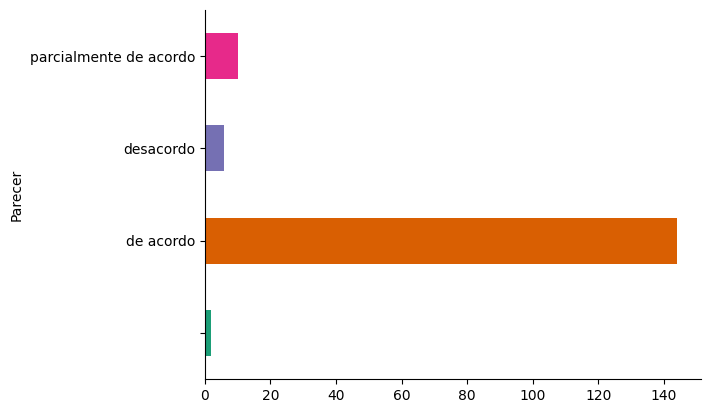

In [ ]:
# @title Parecer

from matplotlib import pyplot as plt
import seaborn as sns
grupos_embeddings.groupby('Parecer').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
grupos_embeddings['Parecer'].value_counts()

,count
Parecer,
de acordo,144
parcialmente de acordo,10
desacordo,6
,2


In [ ]:
resumo_embed, resumo_embed_stemmer, resumo_embedd_lemma = [],[],[]

for index, row in votos.iterrows():
    resumo_embed.append(get_embeddings(row['Resumo']))
    resumo_embed_stemmer.append(get_embeddings(row['Resumo_Stemmer']))
    resumo_embedd_lemma.append(get_embeddings(row['Resumo_Lemma']))

grupos_embeddings['Resumo_Embed'] = resumo_embed
grupos_embeddings['Resumo_Embed_Stemmer'] = resumo_embed_stemmer
grupos_embeddings['Resumo_Embed_Lemma'] = resumo_embedd_lemma

In [ ]:
grupos_embeddings

,Processo,Doc_Tokens,Resumo_Tokens,Resumo_Tokens_Stemmer,Resumo_Tokens_Lemma,Parecer,Resumo_Embed,Resumo_Embed_Stemmer,Resumo_Embed_Lemma
0,100367-7/2021,4817,1117,793,895,desacordo,"[0.030403117, 0.05800577, -0.05853004, 0.01800...","[0.027827121, 0.07224828, -0.06742317, 0.00528...","[0.026168244, 0.07241898, -0.06625233, 0.03953..."
1,201921-1/2022,4440,968,672,740,desacordo,"[0.029879134, 0.043617934, -0.04742121, 0.0001...","[0.027472515, 0.047113497, -0.0336215, 0.01399...","[0.015437653, 0.047100443, -0.029369613, 0.011..."
2,226191-0/2015,3356,773,512,485,parcialmente de acordo,"[0.03546721, 0.01757197, -0.00023917553, -0.00...","[0.061308756, 0.041659184, -7.582176e-05, 0.02...","[0.05521441, 0.031448342, -0.00014561827, -0.0..."
3,240655-7/2023,2527,648,380,514,desacordo,"[0.041463085, 0.04671753, -0.0377646, -0.00291...","[0.031335115, 0.07783256, -0.012452131, -0.012...","[0.044376407, 0.07072573, -0.03816461, -0.0075..."
4,116465-3/2023,2495,778,302,424,de acordo,"[0.009142156, 0.050908156, -0.026893904, 0.021...","[0.008415833, 0.021333808, -0.045035716, -0.01...","[0.015283152, 0.04938253, -0.038563166, -0.005..."
...,...,...,...,...,...,...,...,...,...
157,207739-2/2024,613,173,163,125,de acordo,"[0.029329583, 0.039889134, -0.0061784196, -0.0...","[0.026444947, 0.036368284, -0.029376881, -0.00...","[0.016863216, 0.03357229, -0.02877176, -0.0128..."
158,105069-8/2024,611,158,183,144,de acordo,"[0.029856438, 0.024153618, -0.003148633, -0.02...","[0.020426264, 0.042358536, -0.015595448, -0.03...","[0.033394974, 0.03718888, -0.02455019, -0.0538..."
159,212611-1/2024,545,140,153,122,,"[-0.014870347, 0.036337763, 0.006765103, 0.003...","[0.020701807, 0.04990998, 0.03841901, 0.006243...","[0.0061008474, 0.06186686, 0.0009920294, -0.00..."
160,211637-8/2024,547,165,139,139,,"[0.0043913294, 0.031487904, 0.018465333, 0.008...","[0.019385792, 0.048441477, 0.024317592, -0.004...","[-0.01961724, 0.05061698, 0.025753291, 0.00710..."


## **Clustering sobre os Embeddigns ($Resumo$)**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Convert df_train['Embeddings'] Pandas series to a np.array of float32
X_resumo = np.array(grupos_embeddings['Resumo_Embed'].to_list(), dtype=np.float32)
X_resumo_stemmer = np.array(grupos_embeddings['Resumo_Embed_Stemmer'].to_list(), dtype=np.float32)
X_resumo_lemma = np.array(grupos_embeddings['Resumo_Embed_Lemma'].to_list(), dtype=np.float32)

print(X_resumo.shape)
print(X_resumo_stemmer.shape)
print(X_resumo_lemma.shape)

(162, 768)
(162, 768)
(162, 768)


In [ ]:
tsne = TSNE(random_state=0, max_iter=250)
tsne_resumo = tsne.fit_transform(X_resumo)

In [ ]:
df_tsne_resumo = pd.DataFrame(tsne_resumo, columns=['TSNE1', 'TSNE2'])
df_tsne_resumo['Parecer'] = grupos_embeddings['Parecer']
df_tsne_resumo

,TSNE1,TSNE2,Parecer
0,-0.121030,0.121581,desacordo
1,-0.144491,-0.059035,desacordo
2,0.156639,0.049728,parcialmente de acordo
3,0.118902,0.000238,desacordo
4,-1.431488,-0.143240,de acordo
...,...,...,...
157,0.316590,0.830973,de acordo
158,-0.042095,-0.102474,de acordo
159,0.157945,-0.028027,
160,-0.115512,-0.110387,


(-12.012688493728637, 6.801557397842407, -6.526178359985352, 7.909863471984863)

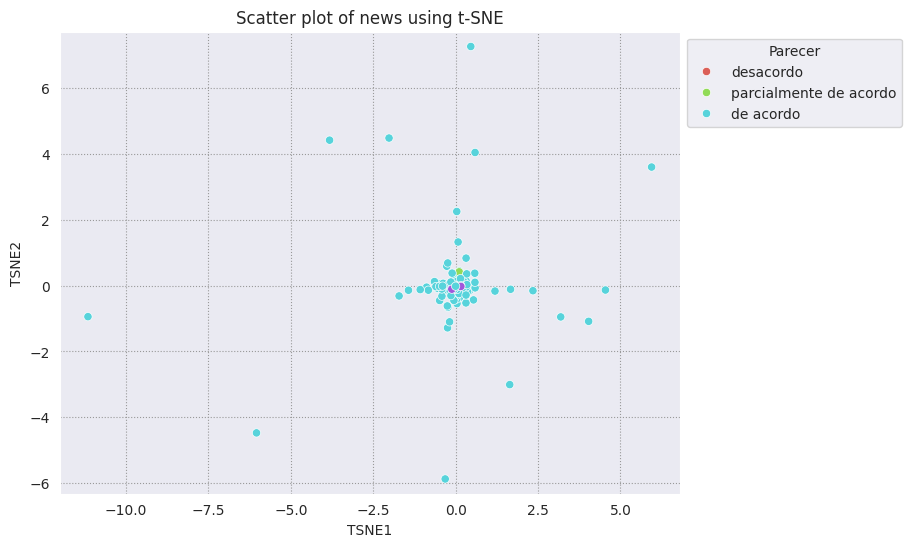

In [ ]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne_resumo, x='TSNE1', y='TSNE2', hue='Parecer', palette='hls')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal')

## **Clustering sobre os Embeddigns ($Resumo$ com $Stemmer$)**

In [ ]:
tsne_resumo_stemmer = tsne.fit_transform(X_resumo_stemmer)

In [ ]:
df_tsne_resumo_stemmer = pd.DataFrame(tsne_resumo_stemmer, columns=['TSNE1', 'TSNE2'])
df_tsne_resumo_stemmer['Parecer'] = grupos_embeddings['Parecer']
df_tsne_resumo_stemmer

,TSNE1,TSNE2,Parecer
0,0.033215,-0.151567,desacordo
1,0.303798,-0.124489,desacordo
2,-0.013090,-0.160329,parcialmente de acordo
3,-0.125224,0.015202,desacordo
4,-0.028174,-0.259563,de acordo
...,...,...,...
157,-0.241555,-0.059055,de acordo
158,0.005112,-0.227306,de acordo
159,-12.268707,-1.618002,
160,0.123190,-0.132226,


(-15.100107765197754,
 47.19070301055908,
 -17.135811018943787,
 5.936607050895691)

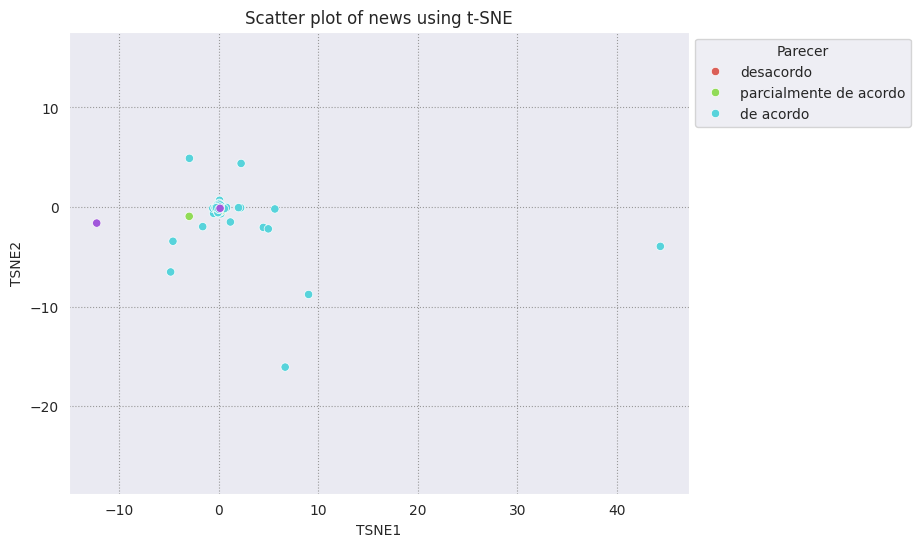

In [ ]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne_resumo_stemmer, x='TSNE1', y='TSNE2', hue='Parecer', palette='hls')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal')

## **Clustering sobre os Embeddigns ($Resumo$ com $Lemma$)**

In [ ]:
tsne_resumo_lemma = tsne.fit_transform(X_resumo_lemma)

In [ ]:
df_tsne_resumo_lemma = pd.DataFrame(tsne_resumo, columns=['TSNE1', 'TSNE2'])
df_tsne_resumo_lemma['Parecer'] = grupos_embeddings['Parecer']
df_tsne_resumo_lemma

,TSNE1,TSNE2,Parecer
0,-0.121030,0.121581,desacordo
1,-0.144491,-0.059035,desacordo
2,0.156639,0.049728,parcialmente de acordo
3,0.118902,0.000238,desacordo
4,-1.431488,-0.143240,de acordo
...,...,...,...
157,0.316590,0.830973,de acordo
158,-0.042095,-0.102474,de acordo
159,0.157945,-0.028027,
160,-0.115512,-0.110387,


(-12.012688493728637, 6.801557397842407, -6.526178359985352, 7.909863471984863)

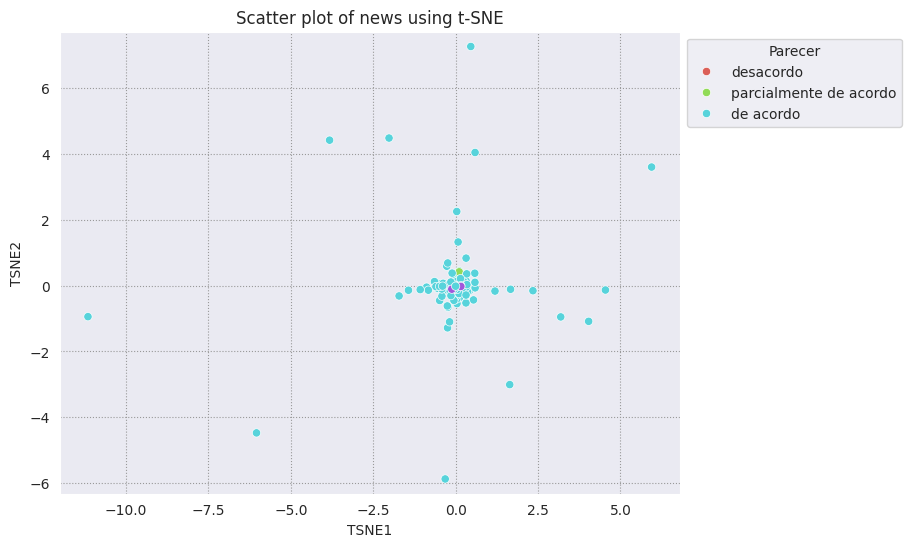

In [ ]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne_resumo_lemma, x='TSNE1', y='TSNE2', hue='Parecer', palette='hls')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal')

## Considerações de abordagem

1. Tempo
2. Custo (Financeiro)
3. Consumo Energético


## Programação Inteira com abordagem por multiobjetivo

